In [53]:
import torch
import pickle
import os
from PIL import Image
from torch.nn.functional import softmax
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
from IPython.utils import io
torch.set_printoptions(sci_mode=False)
import matplotlib.pyplot as plt

In [36]:
def plot_generated(img):
    img_out = (img.permute(0,2,3,1)*127.5 + 128).clamp(0,255).to(torch.uint8)
    img_out = Image.fromarray(img_out[0].cpu().numpy())
    return img_out

## General Setup

In [2]:
# Products data and latents
target_feature = 'category'

In [3]:
import platform
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [4]:
os.chdir(f"{ROOT_PATH}/4_Assessor/Category_Assessor/DinoV2")
from helpers_pipeline import set_device, load_latents, setup_generator
from helper_classifier import set_seed
id2label = pickle.load(open(f"id2label_dicts/{target_feature}_id2label.pkl", "rb"))
label2id = {v: k for k, v in id2label.items()}
os.chdir(current_wd)

Using devices: DinoV2 device: cpu | SG2 device: mps | General device: mps


In [5]:
set_seed(42)
dino_device, sg2_device, device = set_device()

Using devices: DinoV2 device: cpu | SG2 device: mps | General device: mps


## Fixed Models Setup

In [6]:
df, latents = load_latents(target_feature)
latents = latents.to(sg2_device)

In [7]:
df, latents = load_latents(target_feature)
latents = latents.to(sg2_device)

# SG2-Ada Generator
G = setup_generator()
G = G.to(sg2_device)


### Train Single Decision Boundary from SVM for Occasion Wear vs no Occasion Wear

In [8]:
pos = df[df.category == 'Occasion wear']
neg = df[df.category != 'Occasion wear']
pos.shape, neg.shape

((817, 3), (13243, 3))

In [9]:
df = df.sort_values(by='latent_idx')
df['target'] = np.where(df[target_feature] == 'Occasion wear', 1, 0)
df

,sku,category,latent_idx,target
8727,CE321C0DU-K11,Day dress,0,0
4667,FAB21C095-K11,Cocktail dress / Party dress,1,0
4462,IV321C0E5-Q11,Cocktail dress / Party dress,2,0
2634,NN121C0H6-A11,Shift dress,3,0
4044,V1021C48D-H11,Cocktail dress / Party dress,4,0
...,...,...,...,...
1567,L5X21C02L-K11,Jersey dress,14055,0
9594,SI421C03B-E11,Day dress,14056,0
3355,R9821C03T-G11,Occasion wear,14057,1
3002,BB121C0X7-Q11,Shift dress,14058,0


In [20]:
X = latents.squeeze(1)[:,0,:].cpu().numpy()
y = df.target.values

In [14]:
#X = latents.squeeze(1).reshape(14060, -1).cpu().numpy()


In [15]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [23]:
model = make_pipeline(StandardScaler(), SVC(kernel='linear'))

# Fit the model
model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear'))])

In [34]:
hyperplane = model[1].coef_
hyperplane.shape

(1, 512)

### Test some generations

  0%|          | 0/10 [00:00<?, ?it/s]

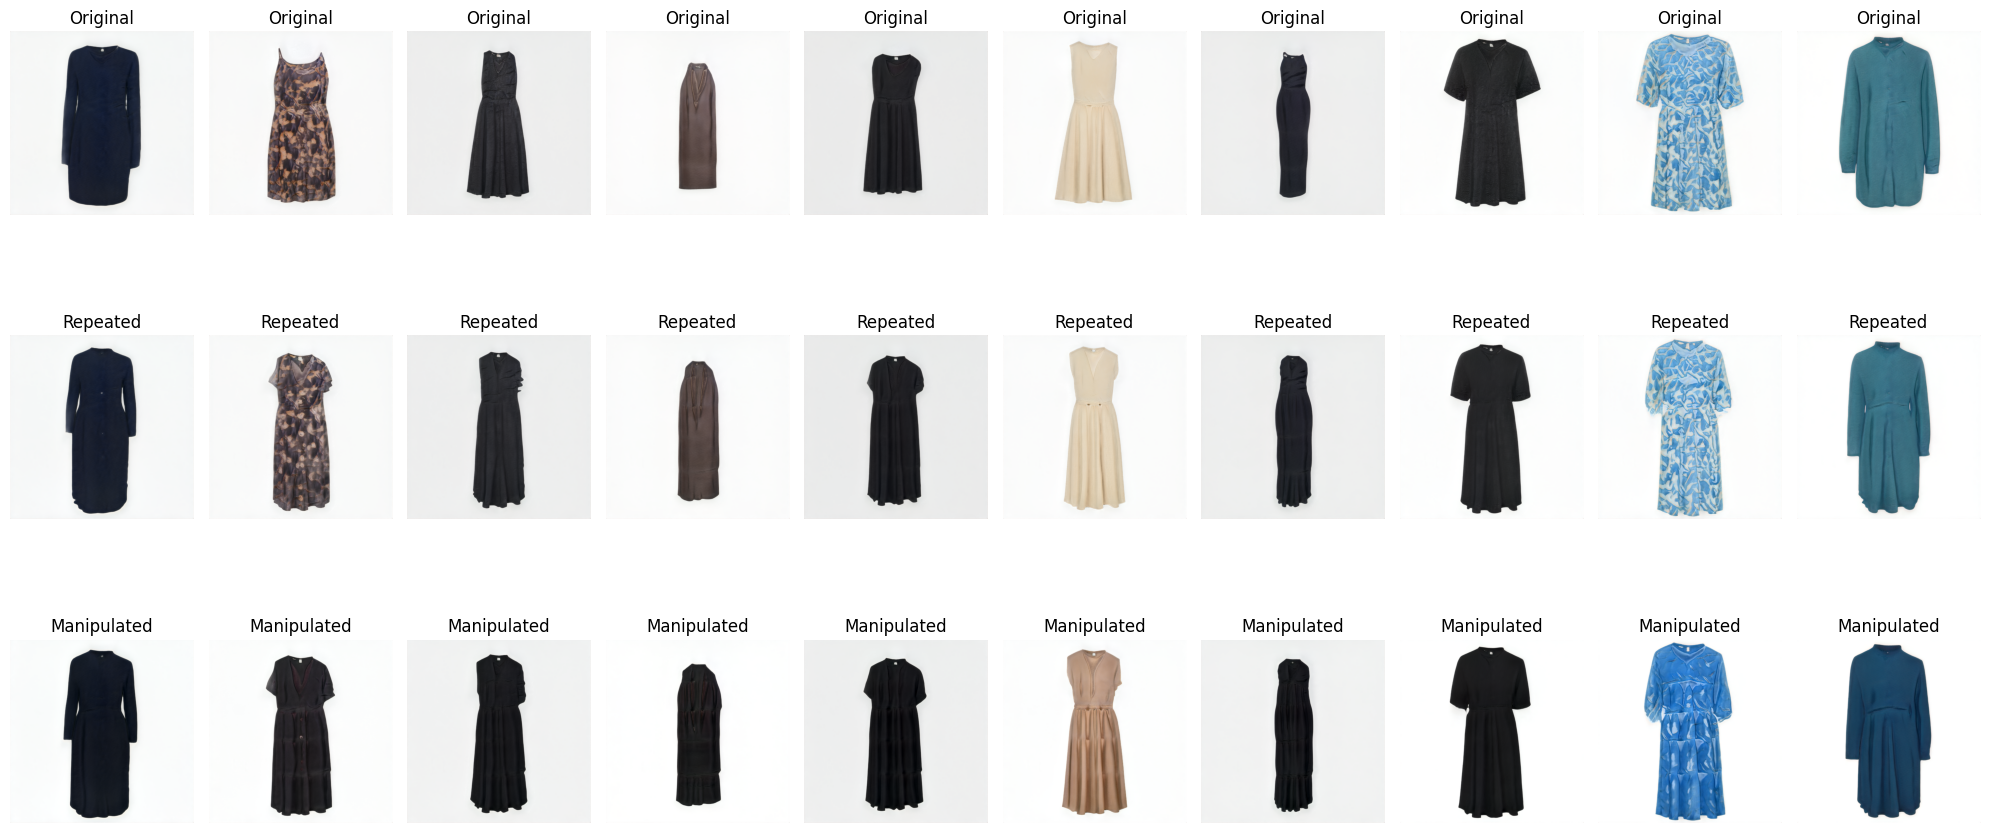

In [54]:
num_samples = 10

fig, ax = plt.subplots(3, num_samples, figsize=(20, 10))
for i in tqdm(range(num_samples)):
    neg_sample = neg.sample(1)
    neg_latent_idx = neg_sample.latent_idx.values[0]
    neg_latent = latents[neg_latent_idx]

    orig = G.synthesis(neg_latent, noise_mode='const')
    latent_repeated = G.synthesis(neg_latent[:,0,:].repeat(16,1).unsqueeze(0), noise_mode='const')
    manipulated = G.synthesis(neg_latent[:,0,:].repeat(16,1).unsqueeze(0) + torch.tensor(hyperplane, dtype=torch.float32).to(sg2_device), noise_mode='const')

    ax[0, i].imshow(plot_generated(orig))
    ax[1, i].imshow(plot_generated(latent_repeated))
    ax[2, i].imshow(plot_generated(manipulated))
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[2, i].axis('off')
    ax[0, i].set_title("Original")
    ax[1, i].set_title("Repeated")
    ax[2, i].set_title("Manipulated")

plt.tight_layout()
plt.show()
    